In [1]:
# Import libraries,
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

print("Libraries imported successfully!")

Libraries imported successfully!


In [44]:
import pandas as pd
import requests

# MTA hourly bridges & tunnels endpoint
MTA_HOURLY_URL = "https://data.ny.gov/resource/qzve-kjga.json"

def fetch_mta_hourly(
    url=MTA_HOURLY_URL,
    start_date="2024-01-01",
    end_date="2025-06-30",
    limit=200_000,
    app_token=None
):
    """
    Fetch hourly bridge/tunnel volumes and return a DataFrame with a
    full timestamp column.

    Schema in the feed:
      • date           : 'YYYY-MM-DD'
      • hour           : '0' … '23'
      • direction      : 'INBOUND' / 'OUTBOUND'
      • vehicles_e_zpass
      • vehicles_vtoll
    """
    
    soql = f"date between '{start_date}' and '{end_date}'"
    params = {"$limit": limit, "$where": soql}
    headers = {"X-App-Token": app_token} if app_token else {}

    resp = requests.get(url, params=params, headers=headers)
    resp.raise_for_status()
    df = pd.DataFrame(resp.json())

   
    df["hour"]                = df["hour"].astype(int)
    df["vehicles_e_zpass"]    = pd.to_numeric(df["vehicles_e_zpass"], errors="coerce")
    df["vehicles_vtoll"]      = pd.to_numeric(df["vehicles_vtoll"],  errors="coerce")

 
    df["date"]      = pd.to_datetime(df["date"]).dt.date              
    df["timestamp"] = (
        pd.to_datetime(df["date"]) +
        pd.to_timedelta(df["hour"], unit="h")
    )

  
    start_ts = pd.to_datetime(start_date)
    end_ts   = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    mask     = (df["timestamp"] >= start_ts) & (df["timestamp"] <= end_ts)
    df       = df.loc[mask].reset_index(drop=True)

   
    df["traffic_volume"] = df["vehicles_e_zpass"].fillna(0) + df["vehicles_vtoll"].fillna(0)

    return df


print("Fetching hourly bridge/tunnel traffic …")
mta_df = fetch_mta_hourly(
    start_date="2024-01-01",
    end_date="2025-06-30",
    limit=200_000
)
print(f"Fetched {len(mta_df)} rows")
print(mta_df[["timestamp","plaza_id","direction","traffic_volume"]].tail())

Fetching hourly bridge/tunnel traffic …
Fetched 200000 rows
                 timestamp plaza_id direction  traffic_volume
199995 2024-01-01 10:00:00       24         O             535
199996 2024-01-01 11:00:00       24         I            1486
199997 2024-01-01 11:00:00       24         O             897
199998 2024-01-01 12:00:00       24         I            1873
199999 2024-01-01 12:00:00       24         O            1140


In [49]:
mta_df.head()

,plaza_id,date,hour,direction,vehicles_e_zpass,vehicles_vtoll,timestamp,traffic_volume,year
0,21,2025-04-12,0,I,2602,652,2025-04-12 00:00:00,3254,2025
1,21,2025-04-12,1,I,1772,506,2025-04-12 01:00:00,2278,2025
2,21,2025-04-12,2,I,1212,348,2025-04-12 02:00:00,1560,2025
3,21,2025-04-12,3,I,1331,335,2025-04-12 03:00:00,1666,2025
4,21,2025-04-12,4,I,1589,353,2025-04-12 04:00:00,1942,2025


In [45]:
# Add a year helper column
mta_df['year'] = mta_df['timestamp'].dt.year

# Count rows by year
yearly_counts = (
    mta_df
      .groupby('year')
      .size()                 # counts rows
      .rename('row_count')     # nicer column name
      .reset_index()
      .sort_values('year')
)

print(yearly_counts)

   year  row_count
0  2024     155955
1  2025      44045


In [50]:
#daily volume

cp_start = pd.Timestamp("2025-01-05")  

mta_in = mta_df[mta_df['direction']=='I'].copy()

daily = (mta_in
         .set_index("timestamp")["traffic_volume"]
         .resample("D").sum()
         .reset_index()
         .rename(columns={"timestamp":"date", "traffic_volume":"daily_vol"}))

daily["period"] = np.where(daily["date"] < cp_start, "Before CP", "After CP")

In [53]:
summary = daily.groupby("period")["daily_vol"].agg(["count","mean","std"]).round(0)
pct = (summary.loc["After CP","mean"] - summary.loc["Before CP","mean"]) / summary.loc["Before CP","mean"] * 100
print(summary)
print(f"\nAverage inbound change: {pct:+.1f}%")

           count      mean      std
period                             
After CP      98  486785.0  43616.0
Before CP    370  507862.0  68493.0

Average inbound change: -4.2%


In [54]:
summary

,count,mean,std
period,,,
After CP,98,486785.0,43616.0
Before CP,370,507862.0,68493.0


In [56]:
from scipy.stats import ttest_ind

before = daily.loc[daily["period"]=="Before CP","daily_vol"]
after  = daily.loc[daily["period"]=="After CP","daily_vol"]

t, p = ttest_ind(before, after, equal_var=False)
print(f"t-stat={t:.2f}  p-value={p:.4f}")

t-stat=3.72  p-value=0.0002


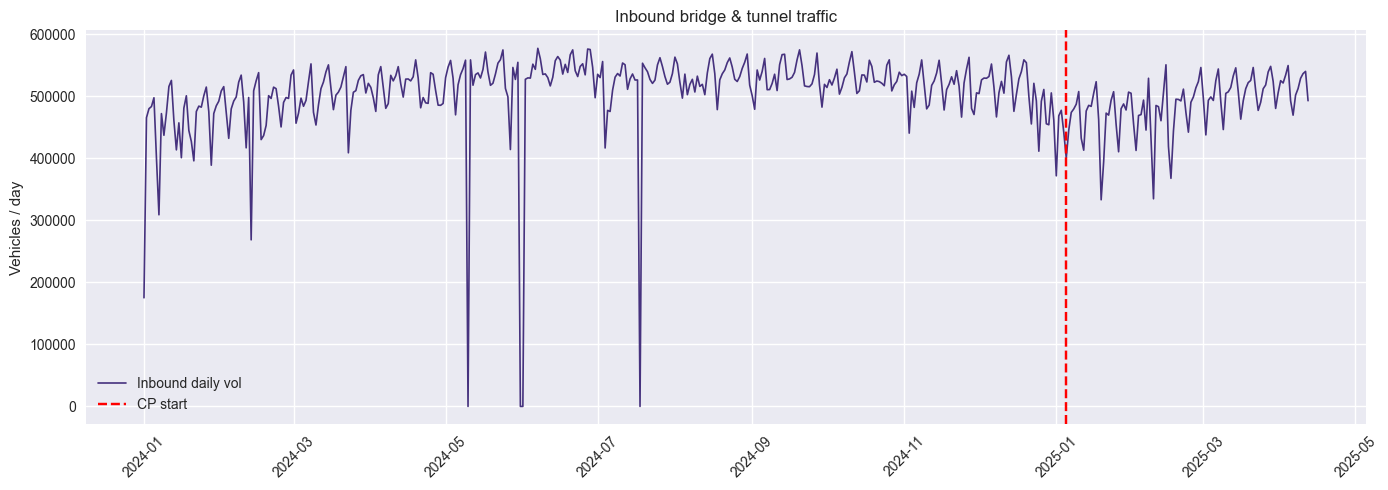

In [55]:
plt.figure(figsize=(14,5))
plt.plot(daily["date"], daily["daily_vol"], lw=1.2, label="Inbound daily vol")
plt.axvline(cp_start, color="red", ls="--", label="CP start")
plt.ylabel("Vehicles / day"); plt.title("Inbound bridge & tunnel traffic");
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()